Review Based Matrix Factorization

In [33]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
from sklearn.metrics import mean_squared_error

In [2]:
rating = pd.read_csv('ratings.csv')
movie = pd.read_csv('movies.csv')
link = pd.read_csv('links.csv')

In [3]:
# Printing data to verify if csv file has been loaded successfully
print(movie.head(3))
print(rating.head(3))

   movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224


In [4]:
# Merging movie and rating matrix based on movieID
movies_ratings = movie.merge(rating, on='movieId', how='left')
print(movies_ratings.head(3))

   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating     timestamp  
0     1.0     4.0  9.649827e+08  
1     5.0     4.0  8.474350e+08  
2     7.0     4.5  1.106636e+09  


In [5]:
# Making user item rating matrix
user_item_ratings = movies_ratings.pivot_table(index='userId', columns=['title'], values='rating')
user_item_ratings

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [6]:
# Counting no of null ratings
total_ratings=0
ratings_given=0
for (row, col), value in np.ndenumerate(user_item_ratings):
  total_ratings=total_ratings+1
  if value>0.0:
    ratings_given=ratings_given+1

print("Total Ratings ", total_ratings)
print("Total Ratings given by users ",ratings_given)
print("Total Ratings not given by users ",total_ratings-ratings_given)

Total Ratings  5928590
Total Ratings given by users  100832
Total Ratings not given by users  5827758


In [7]:
# Filtering the user-item rating matrix
# Find the top 100 users who have rated the most movies
user_ratings_counts = user_item_ratings.sum(axis=1)
top_100_users = user_ratings_counts.sort_values(ascending=False).head(100)

# Calculate the number of ratings each movie has received from the top 100 users
movie_ratings_counts = user_item_ratings.loc[top_100_users.index].sum()

# Sort the movies based on the number of ratings received and keep the top 1000 movies
top_1000_movies = movie_ratings_counts.sort_values(ascending=False).head(1000).index

# Filter the user-item matrix to keep only the top 100 users' ratings and the selected 1000 movies
filtered_user_item_ratings = user_item_ratings.loc[top_100_users.index, top_1000_movies]

# Now, filtered_user_item_ratings contains the ratings of the top 100 users for the top 1000 movies.
filtered_user_item_ratings

title,Forrest Gump (1994),"Matrix, The (1999)",Pulp Fiction (1994),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Fight Club (1999),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Star Wars: Episode VI - Return of the Jedi (1983),...,"Good Night, and Good Luck. (2005)",Strangers on a Train (1951),Modern Times (1936),American Splendor (2003),Whiplash (2014),Patch Adams (1998),Bulworth (1998),"Prince of Egypt, The (1998)",Hulk (2003),Freaky Friday (2003)
userId,,,,,,,,,,,,,,,,,,,,,
414.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,...,4.0,NaN,NaN,4.5,4.0,NaN,3.0,3.0,4.0,3.5
474.0,3.0,4.5,4.0,4.0,5.0,4.0,5.0,4.5,4.0,4.0,...,4.0,4.5,4.5,4.5,NaN,1.0,NaN,5.0,2.5,NaN
599.0,3.5,5.0,5.0,5.0,5.0,5.0,4.0,3.0,3.5,5.0,...,NaN,4.0,NaN,2.5,3.0,NaN,4.0,NaN,3.0,2.5
448.0,3.0,2.0,5.0,5.0,5.0,4.0,NaN,5.0,5.0,5.0,...,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,1.0,NaN
610.0,3.0,5.0,5.0,5.0,5.0,5.0,3.0,4.5,5.0,5.0,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332.0,4.5,5.0,4.0,NaN,4.5,4.5,4.5,4.5,NaN,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104.0,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
325.0,2.0,NaN,5.0,NaN,4.0,NaN,5.0,5.0,NaN,NaN,...,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
total_ratings=0
ratings_given=0
for (row, col), value in np.ndenumerate(filtered_user_item_ratings):
  total_ratings=total_ratings+1
  if value>0.0:
    ratings_given=ratings_given+1

print("Total Ratings ", total_ratings)
print("Total Ratings given by users ",ratings_given)
print("Total Ratings not given by users ",total_ratings-ratings_given)

Total Ratings  100000
Total Ratings given by users  31878
Total Ratings not given by users  68122


In [9]:
user_item_ratings = filtered_user_item_ratings
user_item_ratings.reset_index(drop=True, inplace=True)
user_item_ratings = user_item_ratings.fillna(0)
user_item_ratings

title,Forrest Gump (1994),"Matrix, The (1999)",Pulp Fiction (1994),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Fight Club (1999),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Star Wars: Episode VI - Return of the Jedi (1983),...,"Good Night, and Good Luck. (2005)",Strangers on a Train (1951),Modern Times (1936),American Splendor (2003),Whiplash (2014),Patch Adams (1998),Bulworth (1998),"Prince of Egypt, The (1998)",Hulk (2003),Freaky Friday (2003)
0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,...,4.0,0.0,0.0,4.5,4.0,0.0,3.0,3.0,4.0,3.5
1,3.0,4.5,4.0,4.0,5.0,4.0,5.0,4.5,4.0,4.0,...,4.0,4.5,4.5,4.5,0.0,1.0,0.0,5.0,2.5,0.0
2,3.5,5.0,5.0,5.0,5.0,5.0,4.0,3.0,3.5,5.0,...,0.0,4.0,0.0,2.5,3.0,0.0,4.0,0.0,3.0,2.5
3,3.0,2.0,5.0,5.0,5.0,4.0,0.0,5.0,5.0,5.0,...,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,1.0,0.0
4,3.0,5.0,5.0,5.0,5.0,5.0,3.0,4.5,5.0,5.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4.5,5.0,4.0,0.0,4.5,4.5,4.5,4.5,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
97,2.0,0.0,5.0,0.0,4.0,0.0,5.0,5.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,4.5,5.0,4.0,4.0,0.0,4.5,4.5,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
user_item_ratings_test = user_item_ratings.copy()
user_item_ratings_test.iloc[:, :] = 0

# Find non-zero indices (ratings) to move to the testing dataset
non_zero_indices = np.argwhere(user_item_ratings.values)
print(len(non_zero_indices))
shuffled_indices = np.random.permutation(non_zero_indices)
num_ratings_to_move = int(0.2 * len(shuffled_indices))  # 20% of the non-zero ratings for testing
print(num_ratings_to_move)

for i in range(num_ratings_to_move):
  row, col = shuffled_indices[i]
  user_item_ratings_test.iat[row, col] = user_item_ratings.iat[row, col]
  user_item_ratings.iat[row, col] = 0  # Move the rating to the test set

31878
6375


In [11]:
user_item_ratings_test

title,Forrest Gump (1994),"Matrix, The (1999)",Pulp Fiction (1994),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Fight Club (1999),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Star Wars: Episode VI - Return of the Jedi (1983),...,"Good Night, and Good Luck. (2005)",Strangers on a Train (1951),Modern Times (1936),American Splendor (2003),Whiplash (2014),Patch Adams (1998),Bulworth (1998),"Prince of Egypt, The (1998)",Hulk (2003),Freaky Friday (2003)
0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
1,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,3.0,4.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,4.0,0.0,0.0,4.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
user_item_ratings

title,Forrest Gump (1994),"Matrix, The (1999)",Pulp Fiction (1994),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Fight Club (1999),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Star Wars: Episode VI - Return of the Jedi (1983),...,"Good Night, and Good Luck. (2005)",Strangers on a Train (1951),Modern Times (1936),American Splendor (2003),Whiplash (2014),Patch Adams (1998),Bulworth (1998),"Prince of Egypt, The (1998)",Hulk (2003),Freaky Friday (2003)
0,5.0,5.0,5.0,0.0,5.0,5.0,5.0,0.0,5.0,5.0,...,4.0,0.0,0.0,4.5,4.0,0.0,3.0,3.0,4.0,0.0
1,0.0,4.5,4.0,4.0,5.0,4.0,5.0,4.5,4.0,4.0,...,4.0,4.5,4.5,4.5,0.0,1.0,0.0,5.0,0.0,0.0
2,3.5,5.0,5.0,5.0,5.0,5.0,4.0,0.0,0.0,5.0,...,0.0,4.0,0.0,2.5,3.0,0.0,0.0,0.0,3.0,2.5
3,0.0,2.0,5.0,5.0,5.0,4.0,0.0,5.0,5.0,5.0,...,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,1.0,0.0
4,3.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,5.0,5.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4.5,5.0,4.0,0.0,4.5,4.5,4.5,4.5,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
97,2.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,4.5,5.0,4.0,0.0,0.0,4.5,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Content Based Approach

In [13]:
movies_details = movie.merge(link, on='movieId', how='left')
print(movies_details.sample(10))

      movieId                                            title  \
5865    32862                  With Six You Get Eggroll (1968)   
8706   124273               Kevin Smith: Too Fat For 40 (2010)   
3759     5244                           Shogun Assassin (1980)   
7531    84696                            Burke and Hare (2010)   
7042    69118                      In the Electric Mist (2009)   
268       308  Three Colors: White (Trzy kolory: Bialy) (1994)   
5876    33126                           Frisco Kid, The (1979)   
8739   127164               What Happened, Miss Simone? (2015)   
8094   100277                                      Tabu (2012)   
1180     1572                     Contempt (Mépris, Le) (1963)   

                genres   imdbId    tmdbId  
5865    Comedy|Romance    63821   39225.0  
8706            Comedy  1705115   48132.0  
3759  Action|Adventure    81506   15119.0  
7531   Comedy|Thriller  1320239   50204.0  
7042     Drama|Mystery   910905   13975.0  
268      

In [14]:
# Split the 'genres' column into a list of genres
movies_details['genres'] = movies_details['genres'].str.split('|')
movies_details.sample(10)

# finding unique genres set
genre = set()
for i in movie['genres']:
  for j in i.split('|'):
    genre.add(j)

# Create binary columns for each genre
for i in genre:
  movies_details[i] = movies_details['genres'].apply(lambda x: 1 if i in x else 0)

# Normalizing IMBD ratings
min_rating = movies_details['imdbId'].min()
max_rating = movies_details['imdbId'].max()
movies_details['normalized_imdb'] = (movies_details['imdbId'] - min_rating) / (max_rating - min_rating)

# Normalizing TMBD ratings
min_rating = movies_details['tmdbId'].min()
max_rating = movies_details['tmdbId'].max()
movies_details['normalized_tmdb'] = (movies_details['tmdbId'] - min_rating) / (max_rating - min_rating)

# Drop the unnecessary columns
movies_details = movies_details.drop(columns=['(no genres listed)'])
movies_details = movies_details.drop(columns=['imdbId'])
movies_details = movies_details.drop(columns=['tmdbId'])

movies_details.head(10)

,movieId,title,genres,Documentary,Action,IMAX,Crime,Adventure,Drama,Mystery,...,Thriller,Sci-Fi,Animation,War,Film-Noir,Children,Romance,Fantasy,normalized_imdb,normalized_tmdb
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0.013620,0.001636
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0.013475,0.016821
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.013443,0.029677
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0.013641,0.059649
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.013421,0.022562
5,6,Heat (1995),"[Action, Crime, Thriller]",0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0.013449,0.001802
6,7,Sabrina (1995),"[Comedy, Romance]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.013573,0.022558
7,8,Tom and Huck (1995),"[Adventure, Children]",0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0.013333,0.086221
8,9,Sudden Death (1995),[Action],0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.013604,0.017291
9,10,GoldenEye (1995),"[Action, Adventure, Thriller]",0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0.013439,0.001347


In [15]:
# Merging rows with same movies

# Define the columns for which you want to calculate the mean
mean_columns = ['normalized_imdb', 'normalized_tmdb', 'IMAX', 'Children', 'Musical', 'Adventure', 'Documentary',
                'War', 'Western', 'Romance', 'Animation', 'Crime', 'Action', 'Drama', 'Mystery',
                'Fantasy', 'Comedy', 'Horror', 'Film-Noir', 'Sci-Fi', 'Thriller']

final_movies_info = movies_details.groupby('title').agg({
    # 'tag': list,
    'genres': list,
    **{col: 'mean' for col in mean_columns}
})

# Reset the index to have 'title' as a regular column
final_movies_info = final_movies_info.reset_index()

# Display the resulting DataFrame
final_movies_info

,title,genres,normalized_imdb,normalized_tmdb,IMAX,Children,Musical,Adventure,Documentary,War,...,Crime,Action,Drama,Mystery,Fantasy,Comedy,Horror,Film-Noir,Sci-Fi,Thriller
0,'71 (2014),"[[Action, Drama, Thriller, War]]",0.311535,0.479732,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,'Hellboy': The Seeds of Creation (2004),"[[Action, Adventure, Comedy, Documentary, Fant...",0.050567,0.138616,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,'Round Midnight (1986),"[[Drama, Musical]]",0.010742,0.027904,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,'Salem's Lot (2004),"[[Drama, Horror, Mystery, Thriller]]",0.042372,0.069933,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,'Til There Was You (1997),"[[Drama, Romance]]",0.014074,0.062531,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9732,eXistenZ (1999),"[[Action, Sci-Fi, Thriller]]",0.014358,0.003698,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
9733,xXx (2002),"[[Action, Crime, Thriller]]",0.035188,0.014171,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9734,xXx: State of the Union (2005),"[[Action, Crime, Thriller]]",0.039249,0.022214,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9735,¡Three Amigos! (1986),"[[Comedy, Western]]",0.010924,0.015953,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

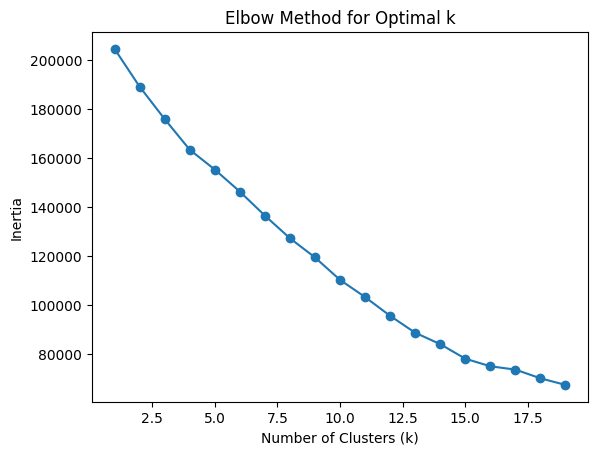

In [16]:
# To determine K value

# Select the columns for clustering
selected_columns = ['normalized_imdb', 'normalized_tmdb', 'IMAX', 'Children', 'Musical', 'Adventure', 'Documentary', 'War', 'Western',
                    'Romance', 'Animation', 'Crime', 'Action', 'Drama', 'Mystery', 'Fantasy',
                    'Comedy', 'Horror', 'Film-Noir', 'Sci-Fi', 'Thriller']

# Prepare the data
data = final_movies_info[selected_columns]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Instantiate the imputer with the strategy you want (e.g., 'mean')
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on your data
scaled_data = imputer.fit_transform(scaled_data)
# Defining a range of k values
k_values = range(1, 20)

# Compute inertias for each k
inertias = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [17]:
# Choose the number of clusters (K)
num_clusters = 15

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
final_movies_info['cluster'] = kmeans.fit_predict(scaled_data)

# Display the clustered data
print(final_movies_info[['title', 'cluster']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                                          title  cluster
0                                    '71 (2014)       14
1       'Hellboy': The Seeds of Creation (2004)        0
2                        'Round Midnight (1986)       11
3                           'Salem's Lot (2004)        7
4                     'Til There Was You (1997)        1
...                                         ...      ...
9732                            eXistenZ (1999)        5
9733                                 xXx (2002)       10
9734             xXx: State of the Union (2005)       10
9735                      ¡Three Amigos! (1986)       12
9736  À nous la liberté (Freedom for Us) (1931)       11

[9737 rows x 2 columns]


In [18]:
# Count the number of movies in each cluster
cluster_counts = final_movies_info['cluster'].value_counts()

# Print the counts for each cluster
print(cluster_counts)

8     1572
4     1440
1     1196
10     845
5      759
9      744
3      617
2      581
7      509
0      398
14     351
11     316
12     164
13     158
6       87
Name: cluster, dtype: int64


In [20]:
# Filtering out the movies which are not there in user-item_rating matrix
common_movies_list = set(final_movies_info['title']).intersection(user_item_ratings.columns)
final_movies_info = final_movies_info[final_movies_info['title'].isin(common_movies_list)]

In [21]:
# Calculate Item Similarity within Clusters
cluster_similarity_matrices = []
for cluster in range(num_clusters):
  cluster_items = final_movies_info[final_movies_info['cluster'] == cluster].title
  cluster_item_similarity = cosine_similarity(user_item_ratings[cluster_items].T)
  cluster_similarity_matrices.append(cluster_item_similarity)

Predict User Ratings

In [22]:
user_id_mapping = {}
new_user_id = 0  # Initialize the new user ID

# Iterate through the original user IDs and assign new user IDs
for original_user_id in user_item_ratings.index:
    user_id_mapping[original_user_id] = new_user_id
    user_item_ratings.rename(index={original_user_id: new_user_id}, inplace=True)
    new_user_id += 1  # Increment the new user ID for the next user

user_item_ratings

title,Forrest Gump (1994),"Matrix, The (1999)",Pulp Fiction (1994),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Fight Club (1999),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Star Wars: Episode VI - Return of the Jedi (1983),...,"Good Night, and Good Luck. (2005)",Strangers on a Train (1951),Modern Times (1936),American Splendor (2003),Whiplash (2014),Patch Adams (1998),Bulworth (1998),"Prince of Egypt, The (1998)",Hulk (2003),Freaky Friday (2003)
0,5.0,5.0,5.0,0.0,5.0,5.0,5.0,0.0,5.0,5.0,...,4.0,0.0,0.0,4.5,4.0,0.0,3.0,3.0,4.0,0.0
1,0.0,4.5,4.0,4.0,5.0,4.0,5.0,4.5,4.0,4.0,...,4.0,4.5,4.5,4.5,0.0,1.0,0.0,5.0,0.0,0.0
2,3.5,5.0,5.0,5.0,5.0,5.0,4.0,0.0,0.0,5.0,...,0.0,4.0,0.0,2.5,3.0,0.0,0.0,0.0,3.0,2.5
3,0.0,2.0,5.0,5.0,5.0,4.0,0.0,5.0,5.0,5.0,...,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,1.0,0.0
4,3.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,5.0,5.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4.5,5.0,4.0,0.0,4.5,4.5,4.5,4.5,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
97,2.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,4.5,5.0,4.0,0.0,0.0,4.5,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
cluster_similarity_matrices

[array([[1.        , 0.53310226, 0.29451453, 0.35779432, 0.41651987],
        [0.53310226, 1.        , 0.28016128, 0.34517961, 0.46918505],
        [0.29451453, 0.28016128, 1.        , 0.25062277, 0.32828548],
        [0.35779432, 0.34517961, 0.25062277, 1.        , 0.26946514],
        [0.41651987, 0.46918505, 0.32828548, 0.26946514, 1.        ]]),
 array([[1.        , 0.30462765, 0.37477023, ..., 0.12821514, 0.33630792,
         0.57709069],
        [0.30462765, 1.        , 0.34670567, ..., 0.30268793, 0.52345957,
         0.30941007],
        [0.37477023, 0.34670567, 1.        , ..., 0.16228322, 0.37424829,
         0.30054498],
        ...,
        [0.12821514, 0.30268793, 0.16228322, ..., 1.        , 0.23464147,
         0.12908984],
        [0.33630792, 0.52345957, 0.37424829, ..., 0.23464147, 1.        ,
         0.15703834],
        [0.57709069, 0.30941007, 0.30054498, ..., 0.12908984, 0.15703834,
         1.        ]]),
 array([[1.        , 0.39051955, 0.39662569, ..., 0.10465

In [24]:
final_movies_info

,title,genres,normalized_imdb,normalized_tmdb,IMAX,Children,Musical,Adventure,Documentary,War,...,Action,Drama,Mystery,Fantasy,Comedy,Horror,Film-Noir,Sci-Fi,Thriller,cluster
8,(500) Days of Summer (2009),"[[Comedy, Drama, Romance]]",0.121811,0.037878,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
18,10 Things I Hate About You (1999),"[[Comedy, Romance]]",0.017563,0.009415,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
23,101 Dalmatians (1996),"[[Adventure, Children, Comedy]]",0.013706,0.022204,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
24,101 Dalmatians (One Hundred and One Dalmatians...,"[[Adventure, Animation, Children]]",0.006535,0.023262,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
34,12 Angry Men (1957),[[Drama]],0.005919,0.000736,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9708,Zero Effect (1998),"[[Comedy, Mystery, Thriller]]",0.014358,0.030716,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,7
9713,Zodiac (2007),"[[Crime, Drama, Thriller]]",0.052826,0.003704,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10
9717,Zombieland (2009),"[[Action, Comedy, Horror]]",0.137755,0.037869,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,9
9721,Zoolander (2001),[[Comedy]],0.023334,0.017875,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8


In [25]:
pre_user_item_matrix = user_item_ratings.copy()
c=0

for user in range(user_item_ratings.shape[0]):
  for item in range(user_item_ratings.shape[1]):
    if user_item_ratings.iat[user, item] == 0.0:
        unrated_movie_name = user_item_ratings.columns[item]

        # Find the cluster of the unrated item
        # item_cluster = final_movies_info.loc[item]['cluster']

        item_cluster = None  # Initialize item_cluster as None

        for index, row in final_movies_info.iterrows():
          if row['title'] == unrated_movie_name:
            item_cluster = row['cluster']
            break  # Exit the loop once a match is found

        if item_cluster is None:
          continue

        # Find the items in the same cluster as the unrated item
        cluster_items = final_movies_info[final_movies_info['cluster'] == item_cluster].title
        movie_list = []
        for i in cluster_items:
          movie_list.append(i)

        # find position of item in cluster_items
        index_of_item = cluster_items[cluster_items == user_item_ratings.columns[item]].index
        if index_of_item>=len(cluster_items):
          continue

        item_similarity_list = []
        for i in cluster_similarity_matrices[item_cluster][index_of_item]:
          for j in i:
            item_similarity_list.append(j)

        # Removing the same movie from the list
        if unrated_movie_name in movie_list:
          index_to_remove = movie_list.index(unrated_movie_name)
          movie_list.pop(index_to_remove)
          item_similarity_list.pop(index_to_remove)

        # Find the top-k most similar items within the same cluster
        if len(movie_list) > 0:
          pairs = list(zip(item_similarity_list, movie_list))
          sorted_pairs = sorted(pairs, key=lambda x: x[0], reverse=True)

          # Extract the top-k similar items and their scores
          k = 10
          if k > len(sorted_pairs):
            k = len(sorted_pairs)  # Ensure k doesn't exceed the number of available items
          top_k_sorted_pairs = sorted_pairs[:k]

          if top_k_sorted_pairs:
            top_10_sorted_score, top_10_sorted_movie = zip(*top_k_sorted_pairs)
          else:
          # Handle the case when there are no items in the cluster
            top_10_sorted_score = []
            top_10_sorted_movie = []
        else:
        # Handle the case when there are no items in the cluster
          top_10_sorted_score = []
          top_10_sorted_movie = []


        # Calculate the predicted rating as the weighted average of ratings of the top-k similar items within the same cluster
        num = 0
        den = 0
        for i in range(k):
          num = num + (top_10_sorted_score[i] * user_item_ratings.iloc[user,user_item_ratings.columns.get_loc(top_10_sorted_movie[i])])
          den = den + top_10_sorted_score[i]
        if den==0:
          continue
        else:
          pre_user_item_matrix.iat[user, item] = num/den
        if pre_user_item_matrix.iat[user, item]>0.0:
          c=c+1

print(pre_user_item_matrix)

title  Forrest Gump (1994)  Matrix, The (1999)  Pulp Fiction (1994)  \
0                      5.0                 5.0                  5.0   
1                      0.0                 4.5                  4.0   
2                      3.5                 5.0                  5.0   
3                      0.0                 2.0                  5.0   
4                      3.0                 5.0                  5.0   
..                     ...                 ...                  ...   
95                     4.5                 5.0                  4.0   
96                     0.0                 0.0                  0.0   
97                     2.0                 0.0                  0.0   
98                     4.5                 5.0                  4.0   
99                     3.5                 2.5                  0.0   

title  Star Wars: Episode IV - A New Hope (1977)  \
0                                            0.0   
1                                          

In [29]:
# Number of latent factors
num_factors = 20

# Convert user_item_matrix to a compatible sparse format
user_item_matrix_sparse = csc_matrix(pre_user_item_matrix, dtype=float)

# Perform SVD on the user-item matrix
U, sigma, Vt = svds(user_item_matrix_sparse, k=num_factors)

# Convert sigma to a diagonal matrix
sigma_diag = np.diag(sigma)

# Predict user-item ratings using the SVD components
predicted_user_item_matrix = np.dot(np.dot(U, sigma_diag), Vt)

# Predict the rating for user 0 and item 0
user_id = 0
item_id = 0
predicted_rating = predicted_user_item_matrix[user_id, item_id]
print(f"Predicted rating for user {user_id} and item {item_id}: {predicted_rating}")

Predicted rating for user 0 and item 0: 5.1890214193887


In [30]:
# Recommending top 10 movies for user 50
target_user_index = 50

# Set the number of neighbors (K)
K = 10

# Predict ratings for unrated items for the target user
target_user_ratings = user_item_ratings.loc[target_user_index]
predicted_ratings = np.zeros(user_item_ratings.shape[1])

for item in range(user_item_ratings.shape[1]):
    if target_user_ratings[item] == 0:
        predicted_ratings[item] = predicted_user_item_matrix[target_user_index, item_id]

# Find the indices of the top 10 recommended items
top_10_indices = np.argsort(predicted_ratings)[::-1][:10]

# Get the corresponding movie titles for the top 10 items
top_10_movie_titles = user_item_ratings.columns[top_10_indices]
print("Top 10 Recommended Movies:")
for i in top_10_movie_titles:
  print(i)

Top 10 Recommended Movies:
Freaky Friday (2003)
Miss Congeniality (2000)
Da Vinci Code, The (2006)
Zombieland (2009)
Elf (2003)
Gremlins (1984)
Hellboy (2004)
12 Angry Men (1957)
District 9 (2009)
Serenity (2005)


In [32]:
# Calculate the absolute errors
absolute_errors = np.abs(predicted_user_item_matrix - user_item_ratings_test)

# Calculate the mean of absolute errors to get MAE
mae = np.mean(absolute_errors.values)

print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 1.16317841552473


In [35]:
# Calculate the errors
errors = predicted_user_item_matrix - user_item_ratings_test

# Square the errors
squared_errors = errors ** 2

# Calculate the mean squared errors
mse = np.mean(squared_errors.values)

# Calculate RMSE by taking the square root of MSE
rmse = np.sqrt(mse)

print("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 1.6145518885295465
